#IMPORT NECESSARY LIBRARIES

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

In [ ]:
import tensorflow as tf
from keras import regularizers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.applications import VGG19, ResNet50V2, InceptionV3, Xception
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical

In [ ]:
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

#DATA PREPARATION

##Define runtime

In [ ]:
!pip install ipython-autotime
%load_ext autotime

time: 326 µs (started: 2024-05-16 13:28:12 +00:00)


##Load Dataset

In [ ]:
!gdown "1WceM5HuxdSiQBzMvhLdKZH88xohgCXaw"
!unzip /content/shoe_sandal_boot.zip

Downloading...
From (original): https://drive.google.com/uc?id=1WceM5HuxdSiQBzMvhLdKZH88xohgCXaw
From (redirected): https://drive.google.com/uc?id=1WceM5HuxdSiQBzMvhLdKZH88xohgCXaw&confirm=t&uuid=d201eaef-51fb-4d7a-8af5-382134a4344f
To: /content/shoe_sandal_boot.zip
100% 49.3M/49.3M [00:00<00:00, 162MB/s]
Archive:  /content/shoe_sandal_boot.zip
replace Shoe vs Sandal vs Boot Dataset/Boot/boot (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
time: 8.04 s (started: 2024-05-16 13:28:12 +00:00)


(102, 136, 3)


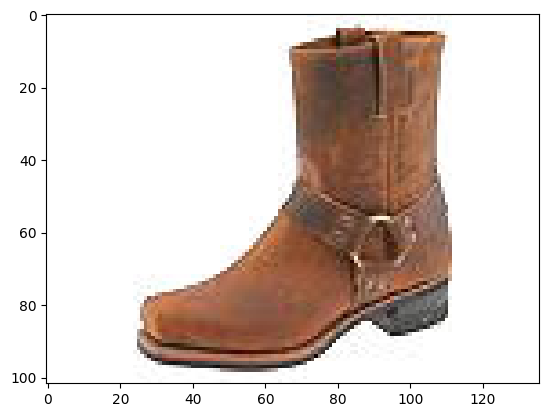

time: 393 ms (started: 2024-05-16 13:28:20 +00:00)


In [ ]:
img = cv2.imread(f'/content/Shoe vs Sandal vs Boot Dataset/Boot/boot (1).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print(img.shape)
del img

In [ ]:
# Path to your image folder
data_dir = "/content/Shoe vs Sandal vs Boot Dataset/"
data_shoe = data_dir + "Shoe/"
data_sandal = data_dir + "Sandal/"
data_boot = data_dir + "Boot/"

# Type of images
shoe = "Shoe"
sandal = "Sandal"
boot = "boot"

# Get all image file paths
shoe_images = [os.path.join(data_shoe, filename) for filename in os.listdir(data_shoe)]
sandal_images = [os.path.join(data_sandal, filename) for filename in os.listdir(data_sandal)]
boot_images = [os.path.join(data_boot, filename) for filename in os.listdir(data_boot)]

time: 28.9 ms (started: 2024-05-16 13:28:21 +00:00)


In [ ]:
print(len(shoe_images))
print(len(sandal_images))
print(len(boot_images))

5000
5000
5000
time: 3.85 ms (started: 2024-05-16 13:28:21 +00:00)


In [ ]:
def load_images(all_images, data_path, data_type):
    images = []
    # print(len(all_images))
    # print(data_path)
    # print(data_type)
    # print(f"{data_path}{data_type} (1).jpg")
    for index in range(1, len(all_images) + 1):
        img = cv2.imread(f"{data_path}{data_type} ({index}).jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (204, 153))
        images.append(img)
    return np.array(images)

shoe_data = load_images(shoe_images, data_shoe, shoe)
sandal_data = load_images(sandal_images, data_sandal, sandal)
boot_data = load_images(boot_images, data_boot, boot)
# images = train_images
print(len(shoe_data))
print(len(sandal_data))
print(len(boot_data))


5000
5000
5000
time: 9.52 s (started: 2024-05-16 13:28:21 +00:00)


Test correct index:

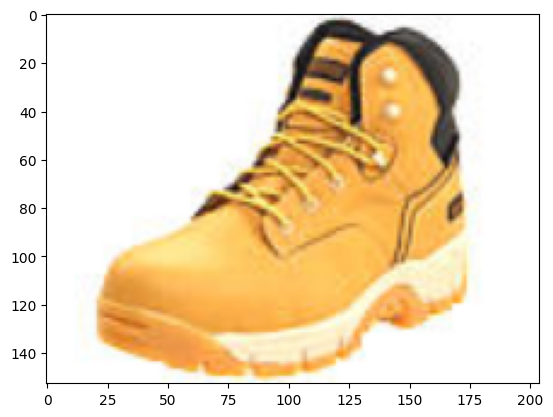

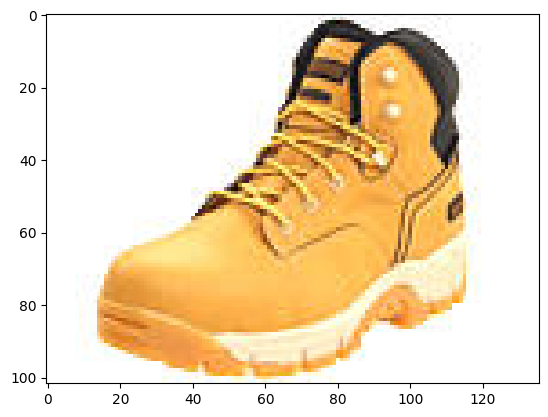

time: 920 ms (started: 2024-05-16 13:28:30 +00:00)


In [ ]:
plt.imshow(boot_data[500])
plt.show()

img = cv2.imread('/content/Shoe vs Sandal vs Boot Dataset/Boot/boot (501).jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
del img

In [ ]:
print(boot_data[500].shape)

(153, 204, 3)
time: 1.22 ms (started: 2024-05-16 13:28:31 +00:00)


#MODEL IMPLEMENTATION

##Models Initialization

###Define a custom CNN model

In [ ]:
def custom_cnn_model():
    # Define the CNN model
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(153, 204, 3), activation='relu'))  # Layer 1
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Layer 2
    model.add(Conv2D(64, (3, 3), activation='relu'))  # Layer 3
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Layer 4
    model.add(Conv2D(128, (3, 3), activation='relu'))  # Layer 5
    model.add(MaxPooling2D(pool_size=(2, 2)))  # Layer 6
    model.add(Flatten())  # Layer 7
    model.add(Dense(units=128, activation='relu'))  # Layer 8
    model.add(Dropout(0.1))
    model.add(Dense(units=3, activation='softmax'))  # Layer 9

    return model


customCNN = custom_cnn_model()

time: 1.46 s (started: 2024-05-16 13:28:31 +00:00)


In [ ]:
customCNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 151, 202, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 101, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 99, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 47, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 23, 128)       0

##Model works

In [ ]:
def train_model(model, optimizer, shoe_data, sandal_data, boot_data, epochs=10, validation_split=0.2):
    # Split each class into training and testing sets
    shoe_train, shoe_test = train_test_split(shoe_data, test_size=validation_split, random_state=42)
    sandal_train, sandal_test = train_test_split(sandal_data, test_size=validation_split, random_state=42)
    boot_train, boot_test = train_test_split(boot_data, test_size=validation_split, random_state=42)


    plt.imshow(shoe_train[5])
    plt.show()
    plt.imshow(shoe_test[5])
    plt.show()
    plt.imshow(sandal_train[5])
    plt.show()
    plt.imshow(sandal_test[5])
    plt.show()
    plt.imshow(boot_train[5])
    plt.show()
    plt.imshow(boot_test[5])
    plt.show()

    # Concatenate the training sets and the testing sets separately
    X_train = np.concatenate([shoe_train, sandal_train, boot_train])
    X_test = np.concatenate([shoe_test, sandal_test, boot_test])

    # Create labels for the training and testing sets
    y_train = np.array([0]*len(shoe_train) + [1]*len(sandal_train) + [2]*len(boot_train))  # 0 for shoe, 1 for sandal, 2 for boot
    y_test = np.array([0]*len(shoe_test) + [1]*len(sandal_test) + [2]*len(boot_test))

    # Convert labels to one-hot vectors
    y_train = to_categorical(y_train, num_classes=3)
    y_test = to_categorical(y_test, num_classes=3)

    # Compile the model with the specified optimizer
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Define the model checkpoint
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), callbacks=[checkpoint])

    # Save the final model to an h5 file
    model.save('final_model.h5')

    return history, model

time: 1.62 ms (started: 2024-05-16 13:28:33 +00:00)


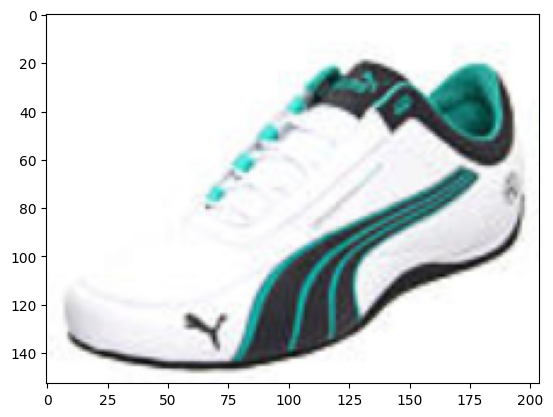

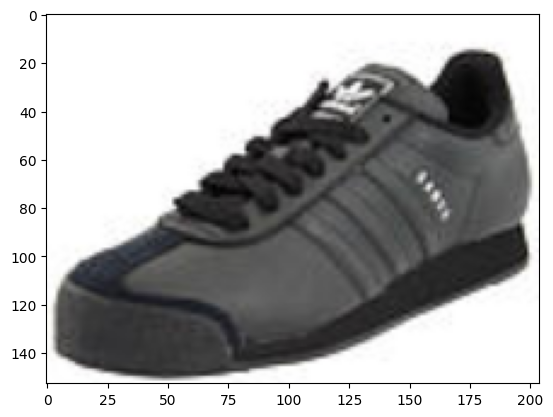

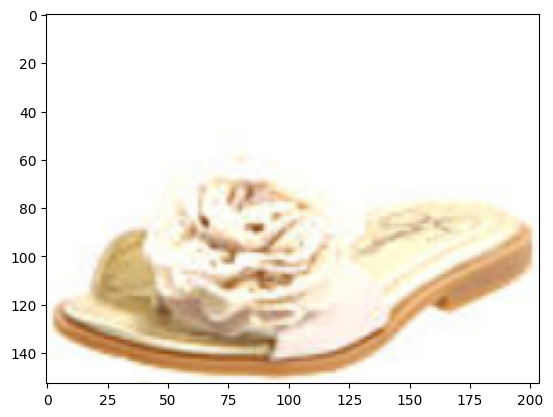

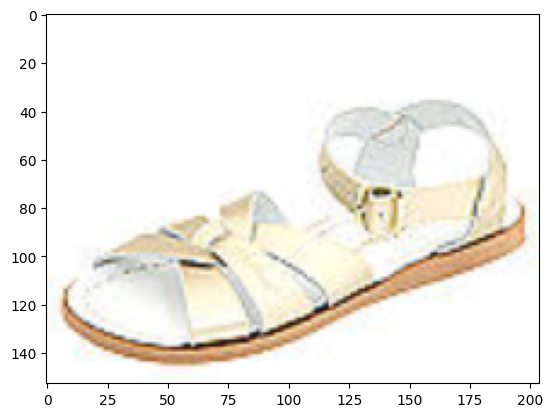

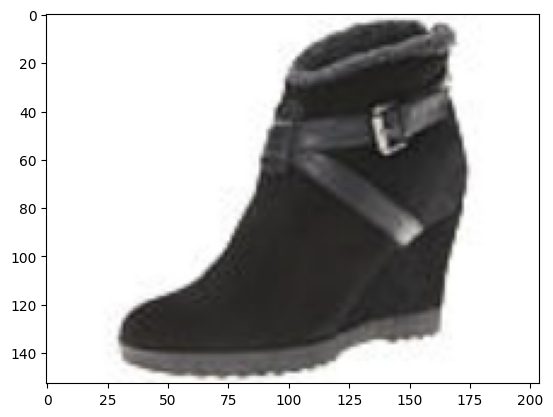

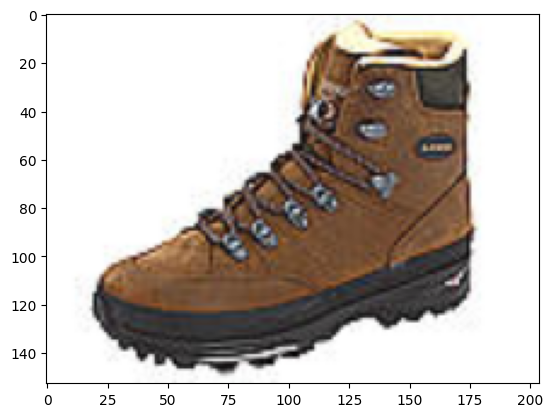

Epoch 1/10
375/375 [==============================] - ETA: 0s - loss: 8.1330 - accuracy: 0.8654
Epoch 1: val_loss improved from inf to 0.18428, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 24s 36ms/step - loss: 8.1330 - accuracy: 0.8654 - val_loss: 0.1843 - val_accuracy: 0.9377
Epoch 2/10
375/375 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.9464
Epoch 2: val_loss did not improve from 0.18428
375/375 [==============================] - 12s 32ms/step - loss: 0.1481 - accuracy: 0.9464 - val_loss: 0.2006 - val_accuracy: 0.9300
Epoch 3/10
375/375 [==============================] - ETA: 0s - loss: 0.0902 - accuracy: 0.9693
Epoch 3: val_loss improved from 0.18428 to 0.12775, saving model to best_model.h5
375/375 [==============================] - 13s 33ms/step - loss: 0.0902 - accuracy: 0.9693 - val_loss: 0.1278 - val_accuracy: 0.9633
Epoch 4/10
375/375 [==============================] - ETA: 0s - loss: 0.0618 - accuracy: 0.9790
Epoch 4: val_loss did not improve from 0.12775
375/375 [==============================] - 12s 33ms/step - loss: 0.0618 - accuracy: 0.9790 - val_loss: 0.1702 - val_accuracy: 0.9537
Epoc

In [ ]:
optimizer = Adam(learning_rate=0.001)

# Pass the model instance directly
history, model = train_model(customCNN, optimizer, shoe_data, sandal_data, boot_data, epochs=10, validation_split=0.2)

In [ ]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img

# Load the saved model
model = load_model('best_model.h5')

# Load the image to test
image = load_img('/content/download (1).jpg', target_size=(153, 204))
image = img_to_array(image)

# Scale the image
# image /= 255
image = np.expand_dims(image, axis=0)

# Predict
predictions = model.predict(image)

# Define the class labels in the order they were used during training
class_labels = ['shoe', 'sandal', 'boot']

# Get the index of the highest probability
predicted_index = np.argmax(predictions)

# Get the name of the predicted class
predicted_class = class_labels[predicted_index]

# Output the prediction
print(f"The model predicts that the image is a {predicted_class}.")


1/1 [==============================] - 0s 83ms/step
The model predicts that the image is a shoe.
time: 525 ms (started: 2024-05-16 13:35:24 +00:00)
